In [215]:
import requests
import bs4 as bs
import pickle

import datetime as dt
import os

import pandas as pd
import pandas_datareader.data as pdr
import pandas_ta as ta

import numpy as np

import math

In [216]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [217]:
DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

In [218]:
df_analisys = pd.read_pickle(DIR_OUTPUTS + 'df_spx500_1d_s1.pkl')

print(df_analisys.shape)
print('\n')

for c in df_analisys.columns.tolist():
    print(c)

(401, 28)


date
last_ss_volume
mean_last3_ss_vols
pred_ss_vol
ss1_vols_c1
ss1_vols_c2
ss1_vols_c3
slope_close_long
slope_close_short
diff_closewpred_close
pp_close_interval_distance
recent_macd_cross
slope_macd
slope_macds
mean_last_macd
mean_last_macdh
pp_vol_last2
slope_close_long_changerate_m0
slope_close_long_changerate_m1
slope_close_long_changerate_diff
Close
Volume
target_order
target_order_bin
target_close
target_profit
target_date
target_date_diff


In [219]:
ls_slope_cols = [
    'date',
    'slope_close_long',
    'slope_close_long_changerate_m0',
    'slope_close_long_changerate_m1',
    'slope_close_long_changerate_diff',
    'slope_close_short',
    'diff_closewpred_close',
    'pp_close_interval_distance',
    'slope_macd',
    'slope_macds',
    'mean_last_macd',
    'mean_last_macdh',
    'recent_macd_cross',
]


df_analisys.iloc[20:,:][ls_slope_cols]

,date,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_long_changerate_diff,slope_close_short,diff_closewpred_close,pp_close_interval_distance,slope_macd,slope_macds,mean_last_macd,mean_last_macdh,recent_macd_cross
20,2020-09-08,-71.662879,-152.498369,-4.229305,-148.269064,-88.219384,-112.960851,8.665546,-85.249759,-69.976497,55.099006,-5.827227,1.0
21,2020-09-09,-81.514925,-9.852046,-152.498369,142.646323,-88.168536,-23.392778,0.807742,-84.224322,-76.548258,45.260002,-12.532984,0.0
22,2020-09-10,-85.339849,-3.824924,-9.852046,6.027122,-88.261816,-44.058463,0.831252,-83.526849,-78.911284,34.701732,-18.473004,0.0
23,2020-09-11,-86.370178,-1.030329,-3.824924,2.794595,-88.001517,-12.885004,0.189189,-83.737477,-80.412458,26.276892,-21.518276,0.0
24,2020-09-14,-86.379036,-0.008858,-1.030329,1.021471,-86.055783,38.130302,0.558492,-79.398616,-80.216269,18.966755,-23.06273,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2022-03-07,-83.098902,-18.532636,9.300256,-27.832892,-87.42547,-84.571699,2.369161,-79.675916,-19.740521,-54.174561,1.004466,1.0
397,2022-03-08,-85.874464,-2.775562,-18.532636,15.757074,-88.470254,-65.044918,1.085899,-83.656621,-64.491054,-59.994407,-3.852304,1.0
398,2022-03-09,-85.168944,0.705519,-2.775562,3.481081,-87.825964,40.578749,0.793808,-66.315478,-64.322401,-65.226285,-7.267345,0.0
399,2022-03-10,-84.679975,0.48897,0.705519,-0.216549,-86.545294,25.111127,0.541221,59.308104,-53.567289,-67.028316,-7.255501,0.0


In [233]:

def weighted_preds(Xp,var,var_weight):
    
    Xp['weight1'] = 1/len(Xp)
    Xp['weight1'] = Xp['weight1'].cumsum()
    Xp['weight1'] = Xp['weight1']/sum(Xp['weight1'])

    Xp['weight2'] = Xp[var_weight]/sum(Xp[var_weight])

    Xp['weight'] = Xp['weight1']*Xp['weight2']
    Xp['weight'] = Xp['weight']/sum(Xp['weight'])

    y = Xp[var].values.reshape(-1, 1)
    w = Xp['weight'].values.reshape(len(Xp),)
    x = np.array([range(0,len(Xp))]).reshape(-1, 1)

    linreg = LinearRegression()

    linreg.fit(x,y,w)
    slope_close = linreg.coef_[0][0]
    yhat = linreg.predict(x)

    Xp['yhat'] = yhat
    Xp['yhat_sup'] = yhat + yhat.std()
    Xp['yhat_inf'] = yhat - yhat.std()
    Xp['slope'] = math.atan(slope_close)*(180/math.pi)

    Xo = Xp[['yhat','yhat_sup','yhat_inf','slope']]

    return Xo

#i=0
i= 1

if i==0:
    Xp = df_analisys[['Close','Volume']].iloc[-(15 + i):]
    date = df_analisys[['date']].iloc[-(15 + i):]
else:
    Xp = df_analisys[['Close','Volume']].iloc[-(15 + i):-i]
    date = df_analisys[['date']].iloc[-(15 + i):-i]

Xout = weighted_preds(Xp,'Close','Volume')
Xout = Xout.rename(columns={'yhat':'pred_close_long',
                            'yhat_sup':'pred_close_long_sup',
                            'yhat_inf':'pred_close_long_inf',
                            'slope':'slope_close_long'})


Xout = pd.concat([Xp,Xout],axis=1)

if i==0:
    Xp = df_analisys[['Close','Volume']].iloc[-(7+i):]
else:
    Xp = df_analisys[['Close','Volume']].iloc[-(7+i):-i]
    
Xout2 = weighted_preds(Xp,'Close','Volume')
Xout2 = Xout2[['yhat','slope']].rename(columns={'yhat':'pred_close_short','slope':'slope_close_short'})

Xout = pd.concat([Xout,Xout2],axis=1)
Xout['slope_close_prom'] = (Xout['slope_close_long'] + Xout['slope_close_short'])/2

#Xout

2022-02-17
2022-03-10


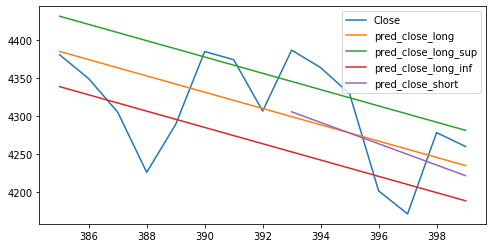

In [234]:
df_obs = Xout[['Close','pred_close_long','pred_close_long_sup','pred_close_long_inf','pred_close_short']]

#print(max(df_analisys['Datetime']))
print(min(date['date']))
print(max(date['date']))
df_obs.plot(figsize=(8,4))

In [232]:
if i==0:
    df_obs2 = df_analisys.iloc[-(15 + i):][ ['Close'] + ls_slope_cols]
else:
    df_obs2 = df_analisys.iloc[-(15 + i):-i][['Close'] + ls_slope_cols]

df_obs2

,Close,date,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_long_changerate_diff,slope_close_short,diff_closewpred_close,pp_close_interval_distance,slope_macd,slope_macds,mean_last_macd,mean_last_macdh,recent_macd_cross
386,4348.870117,2022-02-18,-86.069756,-1.492412,-4.697637,3.205224,-87.332848,-37.417719,0.595008,-80.492094,-45.825023,-40.354325,-1.07929,1.0
387,4304.759766,2022-02-22,-86.89815,-0.828394,-1.492412,0.664018,-87.782754,-40.836212,0.512194,-82.203243,-66.379021,-46.917013,-6.113582,0.0
388,4225.500000,2022-02-23,-87.592743,-0.694593,-0.828394,0.133801,-88.484722,-65.003099,0.632494,-84.471204,-75.566732,-55.639222,-11.868633,0.0
389,4288.700195,2022-02-24,-87.588283,0.00446,-0.694593,0.699053,-88.209436,16.914945,0.164891,-81.652256,-77.426255,-63.438757,-15.734534,0.0
390,4384.649902,2022-02-25,-87.01195,0.576333,0.00446,0.571872,-85.110099,97.607848,1.179263,65.251919,-72.393008,-66.70222,-15.198398,0.0
391,4373.939941,2022-02-28,-85.996431,1.015519,0.576333,0.439186,79.554903,69.203898,1.121062,78.439494,-58.10613,-64.551805,-10.438386,0.0
392,4306.259766,2022-03-01,-85.577707,0.418724,1.015519,-0.596795,79.419438,8.311523,0.148777,39.214454,-47.193668,-61.664452,-6.040827,0.0
393,4386.540039,2022-03-02,-82.195811,3.381896,0.418724,2.963171,85.876831,64.548214,2.047639,72.070107,-13.746415,-58.649292,-2.420533,1.0
394,4363.490234,2022-03-03,-73.866522,8.32929,3.381896,4.947394,85.610251,27.626569,1.84967,77.667049,35.250998,-55.896484,0.265819,1.0
395,4328.870117,2022-03-04,-64.566266,9.300256,8.32929,0.970966,75.488604,-7.453288,0.820383,60.659011,42.79639,-52.501504,2.92864,0.0


In [159]:
len(df_analisys) - 656

-255

In [160]:
df_analisys['predicted_order'] = 'NULL'


#df_analisys.loc[
#    (df_analisys['slope_macd'] < -30)
#    &(df_analisys['slope_macds'] > 10)
#    ,'predicted_order'] = 'BUY'

df_analisys.loc[
    (df_analisys['recent_macd_cross']==1)
    &(df_analisys['slope_macds'] < 0)
    ,'predicted_order'] = 'SELL'


print(df_analisys['predicted_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))



  index  predicted_order
0  NULL              356
1  SELL               45


In [161]:
df_summary = df_analisys.groupby(['target_order','predicted_order'] ).agg(
        orders_quantity = ('date','count'),
        mean_profit = ('target_profit','mean'),
    )

df_summary = df_summary.reset_index()
df_summary['pp_orders'] = df_summary['orders_quantity']/sum(df_summary['orders_quantity'])


df_match = df_summary[
    ((df_summary['target_order'].isin(['BUY','BUY2']))
    &(df_summary['predicted_order'].isin(['BUY'])))
    |
    ((df_summary['target_order'].isin(['SEL','SELL2']))
    &(df_summary['predicted_order'].isin(['SELL'])))
]

pp_match = sum(df_match['orders_quantity'])/sum(df_summary[df_summary['predicted_order'].isin(['NULL'])==False]['orders_quantity'])

print(pp_match)
df_summary

0.08888888888888889


,target_order,predicted_order,orders_quantity,mean_profit,pp_orders
0,BUY,NULL,149,63.786379,0.371571
1,BUY,SELL,16,76.497543,0.039900
2,BUY2,NULL,73,63.646157,0.182045
3,BUY2,SELL,11,97.451816,0.027431
4,NULL,NULL,4,NaN,0.009975
5,NULL,SELL,2,NaN,0.004988
6,SELL,NULL,80,-63.782135,0.199501
7,SELL,SELL,12,-59.948324,0.029925
8,SELL2,NULL,50,-101.225791,0.124688
9,SELL2,SELL,4,-80.860046,0.009975


In [162]:
df_analisys[
(df_analisys['target_order'].isin(['BUY','BUY2']))
&(df_analisys['predicted_order']=='SELL')
][ls_slope_cols+['predicted_order','target_order','Close','target_close','target_profit','target_date']]

,date,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_long_changerate_diff,slope_close_short,diff_closewpred_close,pp_close_interval_distance,slope_macd,slope_macds,mean_last_macd,mean_last_macdh,recent_macd_cross,predicted_order,target_order,Close,target_close,target_profit,target_date
8,2020-08-20,74.639506,-2.164122,-3.877667,1.713545,71.99929,-1.868905,0.198837,-56.382174,-9.146578,52.872873,0.240497,1.0,SELL,BUY,3385.510010,3508.01001,122.5,2020-08-28
10,2020-08-24,81.895224,6.300839,0.95488,5.345959,83.114686,18.619787,1.026949,36.755456,-5.350367,51.549162,-0.704456,1.0,SELL,BUY,3431.280029,3526.649902,95.369873,2020-09-01
20,2020-09-08,-87.778837,-5.196726,-159.932878,154.736152,-88.219384,-58.942068,0.885414,-85.249759,-69.976497,55.099006,-5.827227,1.0,SELL,BUY,3331.840088,3385.48999,53.649902,2020-09-16
62,2020-11-05,88.132113,2.989027,169.001749,-166.012723,88.518603,47.467427,0.599547,84.304384,-4.82349,-10.611729,-6.452766,1.0,SELL,BUY,3510.449951,3585.149902,74.699951,2020-11-13
86,2020-12-10,58.297912,-21.667804,-4.673266,-16.994537,-41.378787,-15.243731,3.646603,-71.033569,-8.380421,56.622727,1.11422,1.0,SELL,BUY,3668.100098,3709.409912,41.309814,2020-12-18
87,2020-12-11,-67.080548,-125.37846,-21.667804,-103.710657,-76.132618,-7.782238,1.27439,-72.993491,-37.140784,53.582407,-1.54088,1.0,SELL,BUY2,3663.459961,3694.919922,31.459961,2020-12-21
110,2021-01-15,-38.222487,-120.018157,-3.319218,-116.698939,-75.737418,-21.642985,10.643395,-69.558533,-1.327122,42.731184,1.392973,1.0,SELL,BUY2,3768.250000,3849.620117,81.370117,2021-01-26
117,2021-01-27,-82.411314,-166.16643,-0.77847,-165.38796,-85.17722,-45.9228,2.369561,-79.58739,-35.587555,42.051216,-0.605727,1.0,SELL,BUY,3750.770020,3871.73999,120.969971,2021-02-04
118,2021-01-28,-84.766822,-2.355508,-166.16643,163.810922,-86.327089,4.526649,0.160574,-80.351885,-60.91293,37.586123,-4.056655,1.0,SELL,BUY,3787.379883,3886.830078,99.450195,2021-02-05
156,2021-03-24,-84.346274,-2.252451,-6.741123,4.488672,-84.784532,-6.988524,0.267951,-73.555497,-20.064935,21.37329,0.327975,1.0,SELL,BUY,3889.139893,4019.870117,130.730225,2021-04-01


In [163]:
len(df_analisys) - 871

-470

In [164]:
df_analisys[
(df_analisys['predicted_order']=='SELL')
][ls_slope_cols+['predicted_order','target_order','Close','target_close','target_profit','target_date',]]

,date,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_long_changerate_diff,slope_close_short,diff_closewpred_close,pp_close_interval_distance,slope_macd,slope_macds,mean_last_macd,mean_last_macdh,recent_macd_cross,predicted_order,target_order,Close,target_close,target_profit,target_date
8,2020-08-20,74.639506,-2.164122,-3.877667,1.713545,71.99929,-1.868905,0.198837,-56.382174,-9.146578,52.872873,0.240497,1.0,SELL,BUY,3385.510010,3508.01001,122.5,2020-08-28
10,2020-08-24,81.895224,6.300839,0.95488,5.345959,83.114686,18.619787,1.026949,36.755456,-5.350367,51.549162,-0.704456,1.0,SELL,BUY,3431.280029,3526.649902,95.369873,2020-09-01
19,2020-09-04,-82.582111,-159.932878,-9.734773,-150.198106,-85.265816,-43.254155,2.181058,-82.515535,-24.470265,64.95171,2.56867,1.0,SELL,SELL2,3426.959961,3401.199951,-25.76001,2020-09-15
20,2020-09-08,-87.778837,-5.196726,-159.932878,154.736152,-88.219384,-58.942068,0.885414,-85.249759,-69.976497,55.099006,-5.827227,1.0,SELL,BUY,3331.840088,3385.48999,53.649902,2020-09-16
52,2020-10-22,-83.603691,1.679995,-0.921321,2.601316,-82.471154,19.238874,0.835298,-62.917184,-5.86162,26.68703,0.908483,1.0,SELL,SELL,3453.489990,3269.959961,-183.530029,2020-10-30
53,2020-10-23,-75.161322,8.442369,1.679995,6.762374,-62.426585,19.473034,1.998097,-34.798837,-12.31637,25.150889,-0.502127,1.0,SELL,SELL2,3465.389893,3310.23999,-155.149902,2020-11-02
62,2020-11-05,88.132113,2.989027,169.001749,-166.012723,88.518603,47.467427,0.599547,84.304384,-4.82349,-10.611729,-6.452766,1.0,SELL,BUY,3510.449951,3585.149902,74.699951,2020-11-13
86,2020-12-10,58.297912,-21.667804,-4.673266,-16.994537,-41.378787,-15.243731,3.646603,-71.033569,-8.380421,56.622727,1.11422,1.0,SELL,BUY,3668.100098,3709.409912,41.309814,2020-12-18
87,2020-12-11,-67.080548,-125.37846,-21.667804,-103.710657,-76.132618,-7.782238,1.27439,-72.993491,-37.140784,53.582407,-1.54088,1.0,SELL,BUY2,3663.459961,3694.919922,31.459961,2020-12-21
104,2021-01-07,84.513449,12.505728,18.339554,-5.833826,85.248622,32.584009,1.212152,70.319193,-9.518049,34.957208,-2.227153,1.0,SELL,SELL,3803.790039,3768.25,-35.540039,2021-01-15


In [165]:
df_obs = df_analisys[
    (df_analisys['date']>=dt.datetime(2022,3,1).date())
    &(df_analisys['date']<=dt.datetime(2022,3,14).date())
][ls_slope_cols+['predicted_order','target_order','Close','target_close','target_profit','target_date',]]

df_obs

,date,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_long_changerate_diff,slope_close_short,diff_closewpred_close,pp_close_interval_distance,slope_macd,slope_macds,mean_last_macd,mean_last_macdh,recent_macd_cross,predicted_order,target_order,Close,target_close,target_profit,target_date
392,2022-03-01,8.466221,67.506892,27.027038,40.479854,79.419438,-21.818148,56.770086,39.214454,-47.193668,-61.664452,-6.040827,0.0,NULL,SELL,4306.259766,4277.879883,-28.379883,2022-03-09
393,2022-03-02,84.467339,76.001118,67.506892,8.494225,85.876831,22.709826,0.851969,72.070107,-13.746415,-58.649292,-2.420533,1.0,SELL,SELL,4386.540039,4259.52002,-127.02002,2022-03-10
394,2022-03-03,85.115532,0.648194,76.001118,-75.352924,85.610251,-10.737023,0.355368,77.667049,35.250998,-55.896484,0.265819,1.0,NULL,SELL,4363.490234,4204.310059,-159.180176,2022-03-11
395,2022-03-04,80.649393,-4.46614,0.648194,-5.114333,75.488604,-29.702198,1.894223,60.659011,42.79639,-52.501504,2.92864,0.0,NULL,NULL,4328.870117,NaN,NaN,NaN
396,2022-03-07,-86.252925,-166.902317,-4.46614,-162.436178,-87.42547,-71.333283,1.80937,-79.675916,-19.740521,-54.174561,1.004466,1.0,SELL,NULL,4201.089844,NaN,NaN,NaN
397,2022-03-08,-88.125531,-1.872606,-166.902317,165.029711,-88.470254,-30.940472,0.392178,-83.656621,-64.491054,-59.994407,-3.852304,1.0,SELL,NULL,4170.700195,NaN,NaN,NaN
398,2022-03-09,-87.744685,0.380846,-1.872606,2.253452,-87.825964,71.901478,1.096711,-66.315478,-64.322401,-65.226285,-7.267345,0.0,NULL,NULL,4277.879883,NaN,NaN,NaN
399,2022-03-10,-86.826408,0.918278,0.380846,0.537432,-86.545294,45.270927,0.972161,59.308104,-53.567289,-67.028316,-7.255501,0.0,NULL,NULL,4259.520020,NaN,NaN,NaN
400,2022-03-11,-86.480992,0.345415,0.918278,-0.572862,-85.999845,2.559455,0.060959,-45.577198,-52.171998,-66.782598,-5.607827,0.0,NULL,NULL,4204.310059,NaN,NaN,NaN


In [ ]:
HIGH DIFFERENCE BETWEEN SLOPES MACDs AND ITS PREVIUOS CHANGES
2022,2,25 BUY 
2022,1,28 BUY

HIGH DIFFERENCE BETWEEN SLOPES MACD AND ITS PREVIUOS CHANGES
2022,2,11 SELL
